<a href="https://colab.research.google.com/github/Adnan-Asif/Parallel-Image-Encryption-using-DNA-mapping-and-Genetic-Algorithm/blob/main/Image_Encryption_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-rek3jqm7
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-rek3jqm7
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4305 sha256=ff6b497bbcb05ed698c92e72e9c8ad9cdafc407175e2fe93627a3b43a31e2c8c
  Stored in directory: /tmp/pip-ephem-wheel-cache-fqvhyov6/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


In [20]:
!wget -nc "https://github.com/mmmovania/CUDA_Spring2023/raw/main/images/Baboon.raw"

--2023-05-06 18:14:16--  https://github.com/mmmovania/CUDA_Spring2023/raw/main/images/Baboon.raw
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mmmovania/CUDA_Spring2023/main/images/Baboon.raw [following]
--2023-05-06 18:14:16--  https://raw.githubusercontent.com/mmmovania/CUDA_Spring2023/main/images/Baboon.raw
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262144 (256K) [image/panasonic-raw]
Saving to: ‘Baboon.raw’

Baboon.raw          100%[===================>] 256.00K  --.-KB/s    in 0.03s   

2023-05-06 18:14:16 (8.33 MB/s) - ‘Baboon.raw’ saved [262144/262144]



#Part 01:
Image Encryption on CPU 

###Running Instructions:
Once the file is downloaded upload the set the file name and the width and the height of the image. 
Then set the name of encrypted file. 
Set the number of generations. 
Upon running this cell, an encrypted text file along with a key.txt file will be produced 

In [21]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <stdint.h>
#include <time.h>



unsigned char *image_file_to_bitstream(const char *image_path, int width, int height) {
    FILE *image_file = fopen(image_path, "rb");
    if (!image_file) {
        fprintf(stderr, "Error: could not open image file '%s'\n", image_path);
        return NULL;
    }

    unsigned char *image_data = (unsigned char*) malloc(sizeof(unsigned char) * width * height);
    if (fread(image_data, sizeof(unsigned char), width * height, image_file) != width * height) {
        fprintf(stderr, "Error: could not read image data from file '%s'\n", image_path);
        fclose(image_file);
        free(image_data);
        return NULL;
    }

    fclose(image_file);

    unsigned char *bitstream = (unsigned char*) malloc(sizeof(unsigned char) * width * height);
    int i, j, index = 0;
    for (i = 0; i < height; i++) {
        for (j = 0; j < width; j++) {
            if (image_data[i * width + j] >= 128) {
                bitstream[index] = 1;
            } else {
                bitstream[index] = 0;
            }
            index++;
        }
    }

    free(image_data);
    return bitstream;
}


unsigned char *generate_random_key(int length) {
    unsigned char *key = (unsigned char*) malloc(sizeof(unsigned char) * length);
    if (!key) {
        fprintf(stderr, "Error: could not allocate memory for key\n");
        return NULL;
    }

    srand(time(NULL));
    int i;
    for (i = 0; i < length; i++) {
        key[i] = rand() % 2;
    }

    return key;
}


void bitxor(unsigned char *bitstream, unsigned char *key, int bitstream_length, int key_length) {
    for (int i = 0; i < bitstream_length; i++) {
        bitstream[i] ^= key[i % key_length];
    }
}

char *bitstream_to_dna(unsigned char *bitstream, int length) {
    char *dna_mapping = (char*) malloc(sizeof(char) * length / 2);
    if (!dna_mapping) {
        fprintf(stderr, "Error: could not allocate memory for DNA mapping\n");
        return NULL;
    }


    for (int i = 0; i < length; i+=2) {
        if ( bitstream[i] == 0 && bitstream[i+1] == 0) {
            dna_mapping[i/2] = 'A';
         } else if (bitstream[i] == 0 && bitstream[i+1] == 1) {
            dna_mapping[i/2] = 'T'; 
        } else if (bitstream[i] == 1 && bitstream[i+1] == 0) {
            dna_mapping[i/2] = 'G';
        } else {
            dna_mapping[i/2] = 'C';
        }
    }
        

    return dna_mapping;
}


void apply_ga(char *dna_map, int generations, int population_size, int chromosome_len, int crossover_points[], int mut_schemes[] ) {
    char mut_table[4][3] = { {'C', 'G', 'T'}, 
                            { 'G', 'T', 'A'}, 
                            { 'A', 'C', 'G' }, 
                            {'T', 'A', 'C'}};
    for (int k = 0; k < generations; ++k) {
        int crossover_point = (rand() % (220 - 40 + 1)) + 40;
        int mut_rule = rand() % 3; 
        crossover_points[k] = crossover_point; 
        mut_schemes[k] = mut_rule;
        for (int i = 0; i < population_size; ++i){
            char * temp_chrom = (char*) malloc(sizeof(char) * chromosome_len);


            for (int j = 0; j < chromosome_len - crossover_point; ++j ) {
                temp_chrom[j] = dna_map[i*chromosome_len + j + crossover_point];
            }

            for (int j = 0; j < crossover_point; ++j ) {
                temp_chrom[chromosome_len - crossover_point + j] = dna_map[i*chromosome_len + j];
            }

            for (int j = 0; j < chromosome_len; ++j) {
                dna_map[i*chromosome_len + j] = temp_chrom[j];
            }

            for (int j = 0; j < chromosome_len; ++j) {
                if (dna_map[i*chromosome_len + j] == 'A') {
                    dna_map[i*chromosome_len + j] = mut_table[0][mut_rule];
                }

                else if (dna_map[i*chromosome_len + j] == 'C') {
                    dna_map[i*chromosome_len + j] = mut_table[1][mut_rule];
                }

                else if (dna_map[i*chromosome_len + j] == 'T') {
                    dna_map[i*chromosome_len + j] = mut_table[2][mut_rule];
                }
                
                else if (dna_map[i*chromosome_len + j] == 'G') {
                    dna_map[i*chromosome_len + j] = mut_table[3][mut_rule];
                }
            }
          free(temp_chrom);
        }

    }
    
}



// ---------- IMAGE PARAMETERS ---------

int WIDTH = 512;
int HEIGHT = 512; 
int IM_SIZE = WIDTH*HEIGHT;


// -------------- GA VARIABLES -------------

int GENERATIONS = 100;
int POPULATION_SIZE = WIDTH;
int CHROMOSOME_LEN = HEIGHT / 2;


int main () {
    
    
  unsigned char * bitstream = image_file_to_bitstream("/content/Baboon.raw", WIDTH, HEIGHT);
  unsigned char * key = generate_random_key(64);


  int crossover_points [GENERATIONS];
  int mut_schemes [GENERATIONS]; 


  clock_t start_t, end_t;
  double total;
  time_t t;



  // ----------------- ENCRYPTION ---------------------

  start_t = clock();

  bitxor(bitstream, key, IM_SIZE, 64);

  char * dna_map = bitstream_to_dna(bitstream, IM_SIZE);

  apply_ga(dna_map, GENERATIONS, POPULATION_SIZE, CHROMOSOME_LEN, crossover_points, mut_schemes);

  end_t = clock();

  // ---------- CREATING ENCRYPTED FILE ------------------

  FILE *fp;
  fp = fopen("/content/encrypted-cpu.txt", "w");

	if(fp == NULL) {
		printf("file couldn't be opened\n");
		exit(1);
	}

   fputs(dna_map,fp);
   fclose(fp);


  FILE *fpointer;
  fpointer = fopen("/content/key-cpu.txt", "w");

	if(fpointer == NULL) {
		printf("file couldn't be opened\n");
		exit(1);
	}

  for (int i = 0; i < 64; ++i) {
      fprintf(fp, "%u", key[i]);
  }
  fprintf(fp, "\n");
  fprintf(fp, "%d %d\n", WIDTH, HEIGHT);
  fprintf(fp, "%d\n", GENERATIONS);

  for (int i = 0; i < GENERATIONS; ++i) {
      fprintf(fp, "%d ", crossover_points[i]);
  }
  fprintf(fp, "\n");
  for (int i = 0; i < GENERATIONS; ++i) {
      fprintf(fp, "%d ", mut_schemes[i]);
  }
  fprintf(fp, "\n");

  
  fclose(fpointer);


// ------------- TIMING -----------

  total = (double)(end_t - start_t) / CLOCKS_PER_SEC;
  printf("Time taken for complete Encryption on CPU: %f seconds\n", total);  








// --------------- TESTING ------------------------

/*
for (int i = 0; i < 64; ++i) {
    printf("%u", key[i]);
}
*/

/*
  for (int i = 0; i < HEIGHT/2; ++i){
      for (int j = 0; j < WIDTH; ++j) {
          printf("%c", dna_map[i*WIDTH + j]);
      }
      printf("\n");
  } 
*/




/*
  for (int i = 0; i < IM_SIZE/2; ++i){
      if (dna_map[i] != 'A' && dna_map[i] != 'G' && dna_map[i] != 'C' && dna_map[i] != 'T') {
          printf("error \n");
      }
  } */



/* 
  for (int i = 0; i < GENERATIONS; ++i) {
    printf("%d %d \n", crossover_points[i], mut_schemes[i]);
  }
  
   */



  // ----------- FREE MEMORY ------------

  free(key);
  free(bitstream);
  free(dna_map);

}




Time taken for complete Encryption on CPU: 0.200484 seconds



#Part 01 continued:
Image decryption on CPU

Set the name of the encrypted file as the input
Upon running this cell a new file will be produced which would be the decrypted version, same as the original file


In [22]:

%%cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <stdint.h>
#include <time.h>


void bitxor(char *bitstream, char *key, int bitstream_length, int key_length) {
    //for (int i = 0; i < bitstream_length; i++) {
      //  bitstream[i] ^= key[i % key_length];
    //}

    for (int i = 0; i < bitstream_length; ++i){
        if (bitstream[i] == '0' && key[i % key_length] == '0') {
            bitstream[i] = '0';
        }
        else if (bitstream[i] == '1' && key[i % key_length] == '1') {
            bitstream[i] = '0';
        }
        else {
            bitstream[i] = '1';
        }
    }
}


void bitstream_to_image_file(char *bitstream, int width, int height, const char *filename) {
    FILE *image_file = fopen(filename, "wb");
    if (!image_file) {
        fprintf(stderr, "Error: could not open image file '%s'\n", filename);
        return;
    }

    char unsigned *image_data = (unsigned char*) malloc(sizeof(unsigned char) * width * height);
    int i, j, index = 0;
    for (i = 0; i < height; i++) {
        for (j = 0; j < width; j++) {
            if (bitstream[index] == '1') {
                image_data[i * width + j] = 255;
            } else {
                image_data[i * width + j] = 0;
            }
            index++;
        }
    }

    fwrite(image_data, sizeof(unsigned char), width * height, image_file);
    fclose(image_file);
    free(image_data);
}

void decrypt_GA(char *dna_map, int generations, int population_size, int chromosome_len, int crossover_points[], int mut_schemes[]) {
    char mut_table[4][3] = { {'T', 'G', 'C'}, 
                            { 'A', 'T', 'G'}, 
                            { 'G', 'C', 'A' }, 
                            {'C', 'A', 'T'}};

    for (int k = generations - 1; k >= 0; --k) {
        int crossover_point = crossover_points[k];
        int mut_rule = mut_schemes[k]; 
        for (int i = 0; i < population_size; i++) {
            
            for (int j = 0; j < chromosome_len; ++j) {
                if (dna_map[i*chromosome_len + j] == 'A') {
                    dna_map[i*chromosome_len + j] = mut_table[0][mut_rule];
                }

                else if (dna_map[i*chromosome_len + j] == 'C') {
                    dna_map[i*chromosome_len + j] = mut_table[1][mut_rule];
                }

                else if (dna_map[i*chromosome_len + j] == 'T') {
                    dna_map[i*chromosome_len + j] = mut_table[2][mut_rule];
                }
                
                else if (dna_map[i*chromosome_len + j] == 'G') {
                    dna_map[i*chromosome_len + j] = mut_table[3][mut_rule];
                }
            }

            char * temp_chrom = (char*) malloc(sizeof(char) * chromosome_len);


            for (int j = 0; j < chromosome_len - crossover_point; ++j ) {
                temp_chrom[j + crossover_point] = dna_map[i*chromosome_len + j];
            }

            for (int j = 0; j < crossover_point; ++j ) {
                temp_chrom[j] = dna_map[i*chromosome_len + j + chromosome_len - crossover_point];
            }

            for (int j = 0; j < chromosome_len; ++j) {
                dna_map[i*chromosome_len + j] = temp_chrom[j];
            }

            free(temp_chrom);
        }
    }
}


char *dna_to_bitstream(char *dna, int length) {
    char *bitstream = (char*) malloc(sizeof(char) * length);
    if (!bitstream) {
        fprintf(stderr, "Error: could not allocate memory for Bitstream\n");
        return NULL;
    }

    for (int i = 0; i < length / 2; i++) {
        if ( dna[i] == 'A') {
            bitstream[i*2] = '0'; 
            bitstream[i*2 + 1] = '0';
        }

        else if ( dna[i] == 'T') {
            bitstream[i*2] = '0'; 
            bitstream[i*2 + 1] = '1';
        }

        else if ( dna[i] == 'G') {
            bitstream[i*2] = '1'; 
            bitstream[i*2 + 1] = '0';
        }
        else {
            bitstream[i*2] = '1'; 
            bitstream[i*2 + 1] = '1';
        }
    }
  

    return bitstream;
}

int main(){

    char *key = (char*) malloc(sizeof(char) * 64);

    clock_t start_t, end_t;
    double total;
    time_t t;
    


    FILE* fp = fopen("/content/key-cpu.txt", "r"); 
    if (fp == NULL) {
        printf("Error: failed to open file\n");
        return 1;
    }

    //fscanf(fp, "%hhu", key);
    for (int i = 0; i < 64; ++i) {
        key[i] = fgetc(fp);
    }

    int width, height;
    fscanf(fp, "%d %d", &width, &height);

    int g;
    fscanf(fp, "%d", &g);
    
    // allocate memory for arrays
    int* crossover_points = (int*) malloc(g * sizeof(int));
    int* mut_schemes = (int*) malloc(g * sizeof(int));
    
\
    for (int i = 0; i < g; i++) {
        fscanf(fp, "%d", &crossover_points[i]);
    }
    
    for (int i = 0; i < g; i++) {
        fscanf(fp, "%d", &mut_schemes[i]);
    }
    
    fclose(fp);

    char *dna= (char*) malloc(sizeof(char) * width * height / 2);

    FILE* ptr;
    ptr = fopen("/content/encrypted-cpu.txt", "r");
    if (NULL == ptr) {
        printf("file can't be opened \n");
    }

    for (int i = 0; i < height*width/2; ++i) {
        dna[i] = fgetc(ptr);
    }
    fclose(ptr);


// ------------------- DECRYPTION ---------------

  start_t = clock();

  decrypt_GA(dna, g, height, width/2, crossover_points, mut_schemes);

  char * dec_bitstream = dna_to_bitstream(dna, height*width); 

  bitxor(dec_bitstream, key, height*width, 64);

  end_t = clock();

  bitstream_to_image_file(dec_bitstream, width, height, "/content/d-Baboon.raw");


  //----------------- TIMING ---------------------

   total = (double)(end_t - start_t) / CLOCKS_PER_SEC;
   printf("Time taken to Decrypt by CPU: %f seconds \n", total);


// --------------- TESTING ------------------------


/*
for (int i = 0; i < 64; ++i) {
    printf("%c", key[i]);
} */



/*
  for (int i = 0; i < 512; ++i){
      for (int j = 0; j < 512; ++j) {
          printf("%c", dec_bitstream[i*512 + j]);
      }
      printf("\n");
  } */



/*
for (int i = 0;  i < g; ++i) {
    printf("%d ", arr2[i]);
} */




// ------------------ FREE MEMORY -------------------

 free(dna);
 free(dec_bitstream);
 free(key);



}


Time taken to Decrypt by CPU: 0.200023 seconds 



#Original Image

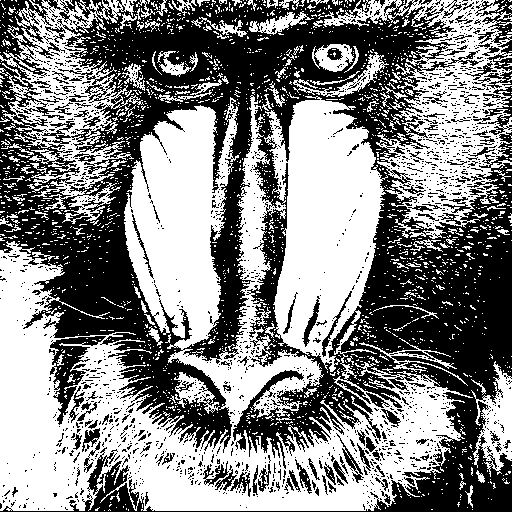

In [23]:
import numpy as np

#lets view our image 
fd = open('/content/d-Baboon.raw', 'rb')
rows = 512
cols = 512
f = np.fromfile(fd, dtype=np.uint8,count=rows*cols)
im = f.reshape((rows, cols)) #notice row, column format
fd.close()

from google.colab.patches import cv2_imshow
#display image using cv2_imshow
cv2_imshow(im)

#Part 02 - Image Encryption on GPU 

Running Instructions are same as above

In [24]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <stdint.h>
#include <time.h>
#include <cuda.h>

inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
  if (err != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}



unsigned char *generate_random_key(int length) {
    unsigned char *key = (unsigned char*) malloc(sizeof(unsigned char) * length);
    if (!key) {
        fprintf(stderr, "Error: could not allocate memory for key\n");
        return NULL;
    }

    srand(time(NULL));
    int i;
    for (i = 0; i < length; i++) {
        key[i] = rand() % 2;
    }

    return key;
}


unsigned char *image_file_to_bitstream(const char *image_path, int width, int height) {
    FILE *image_file = fopen(image_path, "rb");
    if (!image_file) {
        fprintf(stderr, "Error: could not open image file '%s'\n", image_path);
        return NULL;
    }

    unsigned char *image_data = (unsigned char*) malloc(sizeof(unsigned char) * width * height);
    if (fread(image_data, sizeof(unsigned char), width * height, image_file) != width * height) {
        fprintf(stderr, "Error: could not read image data from file '%s'\n", image_path);
        fclose(image_file);
        free(image_data);
        return NULL;
    }

    fclose(image_file);

    unsigned char *bitstream = (unsigned char*) malloc(sizeof(unsigned char) * width * height);
    int i, j, index = 0;
    for (i = 0; i < height; i++) {
        for (j = 0; j < width; j++) {
            if (image_data[i * width + j] >= 128) {
                bitstream[index] = 1;
            } else {
                bitstream[index] = 0;
            }
            index++;
        }
    }

    free(image_data);
    return bitstream;
}



__global__ void bitxorGPU(unsigned char *bitstream, unsigned char *key, int bitstream_length, int key_length) {
    __shared__ unsigned char s_key[64];
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

  
    if (threadIdx.x < key_length){
        s_key[threadIdx.x] = key[threadIdx.x];
    }
    __syncthreads();


    

    if ( idx < bitstream_length) {
        bitstream[idx] ^=  s_key[idx % key_length];
      } 

    //printf("%u \n", bitstream[idx]);
}

__global__ void dnaGPU(unsigned char *bitstream, char* dna_mapping, int length){
    
    int idx = threadIdx.x + blockDim.x*blockIdx.x;
    if (idx < length) {
        if ( bitstream[idx*2] == 0 && bitstream[idx*2+1] == 0) {
            dna_mapping[idx] = 'A';
         } else if (bitstream[idx*2] == 0 && bitstream[idx*2+1] == 1) {
            dna_mapping[idx] = 'T'; 
        } else if (bitstream[idx*2] == 1 && bitstream[idx*2+1] == 0) {
            dna_mapping[idx] = 'G';
        } else {
            dna_mapping[idx] = 'C';
        }
    }
  
}

__global__ void mut_kernel(char *dna_map, int chromosome_len, int p_idx, int mut_scheme) {
    int idx = threadIdx.x + blockDim.x*blockIdx.x;
    char mut_table[4][3] = { {'C', 'G', 'T'}, 
                            { 'G', 'T', 'A'}, 
                            { 'A', 'C', 'G' }, 
                            {'T', 'A', 'C'}};


    if (idx < chromosome_len) {
        if (dna_map[p_idx*chromosome_len + idx] == 'A') {
            dna_map[p_idx*chromosome_len + idx] = mut_table[0][mut_scheme];
        }

        else if (dna_map[idx*chromosome_len + idx] == 'C') {
            dna_map[p_idx*chromosome_len + idx] = mut_table[1][mut_scheme];
        }

        else if (dna_map[p_idx*chromosome_len + idx] == 'T') {
            dna_map[p_idx*chromosome_len + idx] = mut_table[2][mut_scheme];
        }
        
        else if (dna_map[idx*chromosome_len + idx] == 'G') {
            dna_map[p_idx*chromosome_len + idx] = mut_table[3][mut_scheme];
        }
    }
    

    
}

__global__ void applyGA_GPU(char *dna_map, int population_size, int chromosome_len, int crossover_point, int mut_scheme) {
    
    char mut_table[4][3] = { {'C', 'G', 'T'}, 
                            { 'G', 'T', 'A'}, 
                            { 'A', 'C', 'G' }, 
                            {'T', 'A', 'C'}};


    int idx = threadIdx.x + blockDim.x*blockIdx.x;

    //char temp_chrom[512/2];
    char * temp_chrom = (char*) malloc(sizeof(char) * chromosome_len);


    if (idx < population_size) {
       for (int j = 0; j < chromosome_len - crossover_point; ++j ) {
            temp_chrom[j] = dna_map[idx*chromosome_len + j + crossover_point];
        }

        for (int j = 0; j < crossover_point; ++j ) {
            temp_chrom[chromosome_len - crossover_point + j] = dna_map[idx*chromosome_len + j];
        }

        for (int j = 0; j < chromosome_len; ++j) {
            dna_map[idx*chromosome_len + j] = temp_chrom[j];
        } 

        //int NumThreads = 32;
        //int NumBlocks = chromosome_len / NumThreads;
        //mut_kernel<<< NumBlocks, NumThreads >>>(dna_map, chromosome_len, idx, mut_scheme);
        //cudaDeviceSynchronize();



        
        for (int j = 0; j < chromosome_len; ++j) {
                if (dna_map[idx*chromosome_len + j] == 'A') {
                    dna_map[idx*chromosome_len + j] = mut_table[0][mut_scheme];
                }

                else if (dna_map[idx*chromosome_len + j] == 'C') {
                    dna_map[idx*chromosome_len + j] = mut_table[1][mut_scheme];
                }

                else if (dna_map[idx*chromosome_len + j] == 'T') {
                    dna_map[idx*chromosome_len + j] = mut_table[2][mut_scheme];
                }
                
                else if (dna_map[idx*chromosome_len + j] == 'G') {
                    dna_map[idx*chromosome_len + j] = mut_table[3][mut_scheme];
                }
            } 

    }
    free(temp_chrom);


}

// ---------- IMAGE PARAMETERS ---------

int WIDTH = 512;
int HEIGHT = 512; 
int IM_SIZE = WIDTH*HEIGHT;


// -------------- GA VARIABLES -------------

int GENERATIONS = 100;
int POPULATION_SIZE = WIDTH;
int CHROMOSOME_LEN = HEIGHT / 2;

int main () {
    
  unsigned char * bitstream = image_file_to_bitstream("/content/Baboon.raw", WIDTH, HEIGHT);
  unsigned char * key = generate_random_key(64);

  unsigned char * d_key;
  unsigned char * d_bitstream; 
  char *d_dnaMap;

  unsigned char * o_bitstream = (unsigned char*) malloc(sizeof(unsigned char) * IM_SIZE);
  char * o_dnaMap = (char*) malloc(sizeof(char) * IM_SIZE/ 2);

  clock_t start_t, end_t;
  double total;
  time_t t;

  cudaEvent_t start, stop;
	cudaEventCreate(&start);
	cudaEventCreate(&stop);



  int crossover_points [GENERATIONS];
  int mut_schemes [GENERATIONS]; 


  // ----------- Allocating Device Memory ---------------

  checkCudaErr(cudaMalloc(&d_bitstream, sizeof(unsigned char) * IM_SIZE), "cudaMalloc");
  cudaMalloc(&d_key, sizeof(unsigned char) * 64);
  cudaMalloc(&d_dnaMap, sizeof(char) * IM_SIZE/ 2);



  // ------------- Copying from Host to Device --------------


  checkCudaErr(cudaMemcpy(d_bitstream, bitstream, sizeof(unsigned char) * IM_SIZE, cudaMemcpyHostToDevice), "Memcpy");
  checkCudaErr(cudaGetLastError(), "GPU");

  cudaMemcpy(d_key, key, sizeof(unsigned char) * 64, cudaMemcpyHostToDevice);




  // ------------ GPU pe ENCRYPTION -----------------



  int Numthreads = 256;
  int NumOfBlocks = IM_SIZE/ Numthreads;


  start_t = clock();
  bitxorGPU<<< NumOfBlocks , Numthreads >>>(d_bitstream, d_key, IM_SIZE, 64);
  cudaDeviceSynchronize();

  Numthreads = 256/2;
  NumOfBlocks = (IM_SIZE / Numthreads);

  dnaGPU <<<NumOfBlocks , Numthreads>>>(d_bitstream, d_dnaMap, IM_SIZE/2);
  cudaDeviceSynchronize();

   
  

  for (int i = 0; i <  GENERATIONS; ++i) {
      
      Numthreads = 64;
      NumOfBlocks = (512/ Numthreads);
      int crossover_point = (rand() % (220 - 40 + 1)) + 40;
      int mut_rule = rand() % 3; 
      crossover_points[i] = crossover_point; 
      mut_schemes[i] = mut_rule;
      applyGA_GPU <<<NumOfBlocks , Numthreads>>>(d_dnaMap, POPULATION_SIZE, CHROMOSOME_LEN, crossover_point , mut_rule);
      cudaDeviceSynchronize();
  }


 end_t = clock();

  cudaMemcpy(o_bitstream, d_bitstream, sizeof(unsigned char) * IM_SIZE, cudaMemcpyDeviceToHost);
  cudaMemcpy(o_dnaMap, d_dnaMap, sizeof(char) * IM_SIZE / 2, cudaMemcpyDeviceToHost);

 // -------------TIMING----------------

 total = (double)(end_t - start_t) / CLOCKS_PER_SEC;
 printf("Time taken on GPU: %f seconds \n", total);

 // ---------- CREATING ENCRYPTED FILE ------------------

  FILE *fp;
  fp = fopen("/content/encrypted-gpu.txt", "w");

	if(fp == NULL) {
		printf("file couldn't be opened\n");
		exit(1);
	}

   fputs(o_dnaMap,fp);
   fclose(fp);


  FILE *fpointer;
  fpointer = fopen("/content/key-gpu.txt", "w");

	if(fpointer == NULL) {
		printf("file couldn't be opened\n");
		exit(1);
	}

  for (int i = 0; i < 64; ++i) {
      fprintf(fp, "%u", key[i]);
  }
  fprintf(fp, "\n");
  fprintf(fp, "%d %d\n", WIDTH, HEIGHT);
  fprintf(fp, "%d\n", GENERATIONS);

  for (int i = 0; i < GENERATIONS; ++i) {
      fprintf(fp, "%d ", crossover_points[i]);
  }
  fprintf(fp, "\n");
  for (int i = 0; i < GENERATIONS; ++i) {
      fprintf(fp, "%d ", mut_schemes[i]);
  }
  fprintf(fp, "\n");

  
  fclose(fpointer);

 


  // ------------------- Testing --------------------




/*
  for (int i = 0; i < 512; ++i){
      for (int j = 0; j < 512; ++j) {
          printf("%u", o_bitstream[i*512 + j]);
      }
      printf("\n");
  } */

  
  /*
  for (int i = 0; i < 512/2; ++i){
      for (int j = 0; j < 512; ++j) {
          printf("%c", o_dnaMap[i*512 + j]);
      }
      printf("\n");
  } 
*/

/*
  for (int i = 0; i < 512*512/2; ++i){
      if (o_dnaMap[i] != 'A' && o_dnaMap[i] != 'G' && o_dnaMap[i] != 'C' && o_dnaMap[i] != 'T') {
          printf("error \n");
      }
  } */



/*  for (int i = 0; i < GENERATIONS; ++i) {
      printf("%d %d \n", crossover_points[i], mut_schemes[i]);
  } */

  





  // ----------- Copy from Device to Host ------------



  // Free CPU memory 
  free(key);
  free(bitstream);
  free(o_bitstream);
  free(o_dnaMap);

  // Free Device memory
  cudaFree(d_key);
  cudaFree(d_bitstream);
  cudaFree(d_dnaMap);

}




Time taken on GPU: 0.144382 seconds 



#Part 02 continued 

Image Decryption on GPU

In [25]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <stdint.h>
#include <time.h>

__global__ void bitxorGPU(char *bitstream, char *key, int bitstream_length, int key_length) {
    __shared__ char s_key[64];
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

  
    if (threadIdx.x < key_length){
        s_key[threadIdx.x] = key[threadIdx.x];
    }
    __syncthreads();


    

    if ( idx < bitstream_length) {
        if (bitstream[idx] == s_key[idx % key_length]) {
            bitstream[idx] = '0';
        }
        else {
            bitstream[idx] = '1';
        }
      } 
}

void bitstream_to_image_file(char *bitstream, int width, int height, const char *filename) {
    FILE *image_file = fopen(filename, "wb");
    if (!image_file) {
        fprintf(stderr, "Error: could not open image file '%s'\n", filename);
        return;
    }

    char unsigned *image_data = (unsigned char*) malloc(sizeof(unsigned char) * width * height);
    int i, j, index = 0;
    for (i = 0; i < height; i++) {
        for (j = 0; j < width; j++) {
            if (bitstream[index] == '1') {
                image_data[i * width + j] = 255;
            } else {
                image_data[i * width + j] = 0;
            }
            index++;
        }
    }

    fwrite(image_data, sizeof(unsigned char), width * height, image_file);
    fclose(image_file);
    free(image_data);
}

__global__ void dna_to_bits(char *dna, char* bitstream, int length){
    
    int idx = threadIdx.x + blockDim.x*blockIdx.x;

    if (idx < length) {
        if ( dna[idx] == 'A'){
            bitstream[idx*2] = '0';
            bitstream[idx*2+1] = '0';
        }

        else if ( dna[idx] == 'T'){
            bitstream[idx*2] = '0';
            bitstream[idx*2+1] = '1';
        }

         else if ( dna[idx] == 'G'){
            bitstream[idx*2] = '1';
            bitstream[idx*2+1] = '0';
        }

        else {
            bitstream[idx*2] = '1';
            bitstream[idx*2+1] = '1';
        }
    }
    
  
}

__global__ void dec_GA_GPU(char *dna_map, int population_size, int chromosome_len, int crossover_point, int mut_scheme){
    char mut_table[4][3] = { {'T', 'G', 'C'}, 
                            { 'A', 'T', 'G'}, 
                            { 'G', 'C', 'A' }, 
                            {'C', 'A', 'T'}};

    int idx = threadIdx.x + blockDim.x*blockIdx.x;

    char * temp_chrom = (char*) malloc(sizeof(char) * chromosome_len);

    if (idx < population_size) {
        
        for (int j = 0; j < chromosome_len; ++j) {
          if (dna_map[idx*chromosome_len + j] == 'A') {
              dna_map[idx*chromosome_len + j] = mut_table[0][mut_scheme];
          }

          else if (dna_map[idx*chromosome_len + j] == 'C') {
              dna_map[idx*chromosome_len + j] = mut_table[1][mut_scheme];
          }

          else if (dna_map[idx*chromosome_len + j] == 'T') {
              dna_map[idx*chromosome_len + j] = mut_table[2][mut_scheme];
          }
          
          else if (dna_map[idx*chromosome_len + j] == 'G') {
              dna_map[idx*chromosome_len + j] = mut_table[3][mut_scheme];
          }
      }

      for (int j = 0; j < chromosome_len - crossover_point; ++j ) {
            temp_chrom[j + crossover_point] = dna_map[idx*chromosome_len + j];
        }

        for (int j = 0; j < crossover_point; ++j ) {
            temp_chrom[j] = dna_map[idx*chromosome_len + j + chromosome_len - crossover_point];
        }

        for (int j = 0; j < chromosome_len; ++j) {
            dna_map[idx*chromosome_len + j] = temp_chrom[j];
        } 

    }
     
    free(temp_chrom);
}

int main() {
    
    char *key = (char*) malloc(sizeof(char) * 64);

    clock_t start_t, end_t;
    double total;
    time_t t;
    


    FILE* fp = fopen("/content/key-gpu.txt", "r"); 
    if (fp == NULL) {
        printf("Error: failed to open file\n");
        return 1;
    }

    //fscanf(fp, "%hhu", key);
    for (int i = 0; i < 64; ++i) {
        key[i] = fgetc(fp);
    }

    int width, height;
    fscanf(fp, "%d %d", &width, &height);

    int g;
    fscanf(fp, "%d", &g);
    
    // allocate memory for arrays
    int* crossover_points = (int*) malloc(g * sizeof(int));
    int* mut_schemes = (int*) malloc(g * sizeof(int));
    
\
    for (int i = 0; i < g; i++) {
        fscanf(fp, "%d", &crossover_points[i]);
    }
    
    for (int i = 0; i < g; i++) {
        fscanf(fp, "%d", &mut_schemes[i]);
    }
    
    fclose(fp);

    char *dna= (char*) malloc(sizeof(char) * width * height / 2);

    FILE* ptr;
    ptr = fopen("/content/encrypted-gpu.txt", "r");
    if (NULL == ptr) {
        printf("file can't be opened \n");
    }

    for (int i = 0; i < 512*512/2; ++i) {
        dna[i] = fgetc(ptr);
    }
    fclose(ptr);


// -------------------- DEVICE VARIABLES --------------------


    char * d_dna;
    char * d_bitstream;
    char * d_key;


    char * o_bitstream = (char*) malloc(sizeof(char) * width*height);


// ------------------ Allocating Memory -----------------

  cudaMalloc(&d_bitstream, sizeof(char) * width * height);
  cudaMalloc(&d_key, sizeof(char) * 64);
  cudaMalloc(&d_dna, sizeof(char) * width * height/ 2);


// ------------------- HOST TO DEVICE -----------------------

  cudaMemcpy(d_dna, dna, sizeof(char) * width * height / 2, cudaMemcpyHostToDevice);
  cudaMemcpy(d_key, key, sizeof(char) * 64, cudaMemcpyHostToDevice);



// -------------------- DEVICE DECRYPTION ---------------------
  int Numthreads;
  int NumOfBlocks;

  start_t = clock();
  for (int i = g - 1; i >= 0; --i) {
      
      Numthreads = 64;
      NumOfBlocks = (512/ Numthreads);
      int crossover_point = crossover_points[i];
      int mut_scheme = mut_schemes[i];
      dec_GA_GPU<<<NumOfBlocks , Numthreads>>>(d_dna, height, width/2, crossover_point , mut_scheme);
      cudaDeviceSynchronize();
  }

   Numthreads = 256/2;
   NumOfBlocks = (width*height / Numthreads);

   dna_to_bits <<<NumOfBlocks , Numthreads>>>(d_dna, d_bitstream, width*height/2);
   cudaDeviceSynchronize();

   Numthreads = 256;
   NumOfBlocks = 512*512 / Numthreads;

   bitxorGPU<<< NumOfBlocks , Numthreads >>>(d_bitstream, d_key, width*height, 64);
   cudaDeviceSynchronize();

   end_t = clock();

  cudaMemcpy(o_bitstream, d_bitstream, sizeof(char) * width * height, cudaMemcpyDeviceToHost);

  bitstream_to_image_file(o_bitstream, width, height, "/content/d-Baboon-gpu.raw");

  // ----------------------- TIMING ------------------------

  total = (double)(end_t - start_t) / CLOCKS_PER_SEC;
  printf("Time taken to Decrypt by GPU: %f seconds \n", total);

  // ----------------------------- FREE MEMORY -------------------------------

  free(dna);
  free(key);
  free(o_bitstream);

  cudaFree(d_key);
  cudaFree(d_bitstream);
  cudaFree(d_dna);


}

Time taken to Decrypt by GPU: 0.144168 seconds 



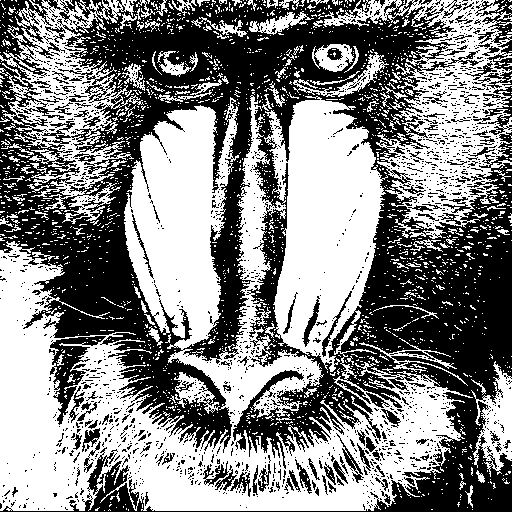

In [26]:
import numpy as np

#lets view our image 
fd = open('/content/d-Baboon-gpu.raw', 'rb')
rows = 512
cols = 512
f = np.fromfile(fd, dtype=np.uint8,count=rows*cols)
im = f.reshape((rows, cols)) #notice row, column format
fd.close()

from google.colab.patches import cv2_imshow
#display image using cv2_imshow
cv2_imshow(im)